In [4]:
from nuscenes.nuscenes import NuScenes
directory = r"/home/kfir/workspace/nuScenes/v1.0-trainval"
nusc = NuScenes(version="v1.0-trainval", dataroot=directory, verbose=False)

In [523]:
%load_ext autoreload
%autoreload 2
from dataset import *
from video import SimulationVideo
from video import NuscenesVideo, NuscenesVideoDebug, PFVideo, PFXYVideo
from MapMatching import MapMatching
from filterpy.kalman import ExtendedKalmanFilter
import math

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [712]:
class DynamicObjectTrack:
    def __init__(self, z, P, create_frame_idx):
        self.kf = ExtendedKalmanFilter(dim_x=4, dim_z=3)
        print(f"z={z}")
        print(z[0]*math.cos(z[1]), z[0]*math.sin(z[1]), z[2]*math.cos(z[1]), z[2]*math.sin(z[1]))
        self.kf.x = np.array([z[0]*np.cos(z[1]), z[0]*np.sin(z[1]), z[2]*np.cos(z[1]), z[2]*np.sin(z[1])])
        self.kf.x = self.kf.x.reshape(-1,1)
        print("self.kf.x.shape", self.kf.x.shape)
        #self.kf.x_prior = np.array([0,0,0,0])
        self.kf.F = np.eye(4)
        self.kf.P = np.diag([1,1,10,10])
        self.kf.P_post = self.kf.P.copy()
        #self.kf.y = np.zeros((1, 3))
        
        self.noise_ax = 9.0
        self.noise_ay = 9.0
        dt = 0.125 # [sec]
        dt_2 = dt*dt
        dt_3 = dt_2*dt;
        dt_4 = dt_3*dt;
        self.kf.Q = np.array([[dt_4/4*self.noise_ax, 0, dt_3/2*self.noise_ax, 0],
                              [0, dt_4/4*self.noise_ay, 0, dt_3/2*self.noise_ay],
                              [dt_3/2*self.noise_ax, 0, dt_2*self.noise_ax, 0],
                              [0, dt_3/2*self.noise_ay, 0, dt_2*self.noise_ay]])
        self.kf.R = np.diag([0.5, 0.01, 0.2])
        self.kf.K = np.zeros((4,3)) # kalman gain
        self.saver = Saver(self.kf)
        self.create_frame_idx = create_frame_idx
        self.last_update_frame_idx = create_frame_idx
        self.hits = 1
        self.age = 1
        self.confirmed = False
    
    def predict(self, dt, dR, dT):
        self.age += 1
        self.kf.F[0, 2] = dt
        self.kf.F[1, 3] = dt
        dt_2 = dt*dt
        dt_3 = dt_2*dt;
        dt_4 = dt_3*dt;
        self.kf.Q = np.array([[dt_4/4*self.noise_ax, 0, dt_3/2*self.noise_ax, 0],
                              [0, dt_4/4*self.noise_ay, 0, dt_3/2*self.noise_ay],
                              [dt_3/2*self.noise_ax, 0, dt_2*self.noise_ax, 0],
                              [0, dt_3/2*self.noise_ay, 0, dt_2*self.noise_ay]])
        self.kf.predict()
        #print(f"dR={dR} dT={dT}")
        #print(f"after predict: self.kf.x_prior={self.kf.x_prior}")
        print(self.kf.x_prior.shape)
        #self.kf.x_prior[0:2] = np.dot(dR, self.kf.x_prior[0:2]) + dT
        #self.kf.x_prior[2:4] = np.dot(dR, self.kf.x_prior[2:4])
        #print(f"after transform: self.kf.x_prior={self.kf.x_prior}")
        print(self.kf.x_prior.shape)
        print(self.kf.x.shape)
        
    def calculateJacobian(self, x):
        Hj = np.zeros([3,4])
        #recover state parameters
        px = x[0];
        py = x[1];
        vx = x[2];
        vy = x[3];

        #pre-compute a set of terms to avoid repeated calculation
        c1 = px*px+py*py
        c2 = np.sqrt(c1)
        c3 = c1*c2

        #check division by zero
        if abs(c1) < 0.0001:
            print("CalculateJacobian () - Error - Division by Zero")
            return Hj

        #compute the Jacobian matrix
        Hj = np.array([[float(px/c2), float(py/c2), 0, 0],
                       [-float(py/c1), float(px/c1), 0, 0],
                       [float(py*(vx*py - vy*px)/c3), float(px*(px*vy - py*vx)/c3), float(px/c2), float(py/c2)]])

        return Hj
    
    
    def Hx(self, x):
        px = x[0];
        py = x[1];
        vx = x[2];
        vy = x[3];
        
        r = math.sqrt(px**2+py**2)
        phi = math.atan2(py,px)
        rho = (px*vx+py*vy)/r
        
        hx = np.array([float(r), float(phi), float(rho)])
        hx=hx.reshape(-1,1)
        print(f"hx.shape={hx.shape}")
        
        return hx
   
    def update(self, z, cov, current_frame_idx):
        self.hits += 1
        print(f"z={z} z.shape={z.shape}")
        
        H = self.calculateJacobian(self.kf.x)
        print("H",H)
        PHT = np.dot(self.kf.P, H.T)
        S = np.dot(H, PHT) + self.kf.R
        print("S.shape",S.shape)
    
    
        self.kf.update(z,HJacobian=self.calculateJacobian,Hx=self.Hx)
        self.last_update_frame_idx = current_frame_idx
        
    def save(self):
        self.saver.save()
        
    def getHistory(self):
        print(self.saver.keys, self.saver._DL["K"])
        print(np.array(self.saver._DL["K"]))
        self.saver.to_array()
        return self.saver.x
    
    def getStateVector(self):
        return self.kf.x
    
    def getPredictedStateVector(self):
        return self.kf.x_prior
        
    def getInnovationCovarianceMatrix(self):
        return self.kf.S
    
    def getCovarianceMatrix(self):
        return self.kf.P_post
    
    def getLastUpdateFrameIdx(self):
        return self.last_update_frame_idx
    

class DynamicTracker:
    def __init__(self):
        self.pnt_data_associator = PointObjectDataAssociator(dim=3,delta=1)
        self.dyn_object_list = []
        self.dyn_max_non_update_iterations = 5
        self.frame_idx = 0
        self.history_dyn_object_list = []
        self.last_ts = 0

    def run(self, z, dz, ts, dR, dT):
        self.frame_idx += 1
        print(f"Number of new plots {len(z)}")
        print(f"Number of dynamic tracks before run() {len(self.dyn_object_list)}")
        
        
        #Prediction
        if self.last_ts > 0:
            dt = (ts - self.last_ts) / 1e6
            self.last_ts = ts
            
            for dyn_track in self.dyn_object_list:
                dyn_track.predict(dt, dR, dT)
        self.last_ts = ts
        
        #Association
        Gp = self.p2t(z)
        
        #Update
        z, dz = self.trackUpdate(z, dz, Gp)
        
        #Init
        self.trackInit(z,dz)
            
        #Maintenance
        self.trackMaintenance()
        
        return self.getTracks()
        
    def p2t(self, measurements):
        Gp = np.zeros((len(measurements), len(self.dyn_object_list)))
        for idx_z, z in enumerate(measurements):
            z = z.reshape(-1,1)
            for idx_track, dyn_track in enumerate(self.dyn_object_list):
                x = dyn_track.getStateVector()
                x_pred = dyn_track.getPredictedStateVector()
                innov_cov = dyn_track.getCovarianceMatrix()
                z_pred = dyn_track.Hx(x_pred)
                z_pred_reshaped = z_pred.reshape(-1,1)
                print(f"z_pred.shape={z_pred.shape} z_pred_reshaped.shape={z_pred_reshaped.shape}")
                print(f"z={z} z_pred={z_pred} R={dyn_track.kf.R}")
                Gp[idx_z,idx_track] = self.pnt_data_associator.calcLikelihood(z, z_pred, dyn_track.kf.R)
        
        #print(f"Gp = {Gp}")
        return Gp
    
    def trackUpdate(self, z, dz, Gp):
        assigned_meas_list = []
        while(1): #Iterate over GP
            i_meas, lp, i_trk = self.getBestAssociation(Gp)
            if(lp == 0):
                break
            self.zeroOutAssociation(Gp, i_meas, i_trk) # Clear from point association matrix
            zm = z[i_meas]
            cov = dz[i_meas]
            assigned_meas_list.append(i_meas)
            
            zm=zm.reshape(-1,1)

            print(f"Updating track = {i_trk} z = {zm} cov={cov}")
            print(f"zm.shape={zm.shape}")
            self.dyn_object_list[i_trk].update(z=zm,cov=cov, current_frame_idx=self.frame_idx)
                
        for i_meas in sorted(assigned_meas_list, reverse=True):
            z = np.delete(z, (i_meas), axis=0)
            dz = np.delete(dz, (i_meas), axis=0)
        
        return z, dz
        
    def trackInit(self, z, dz):
        for z,cov in zip(z,dz):
            print(f"z={z}")
            new_trk = DynamicObjectTrack(z=z, P=cov, create_frame_idx=self.frame_idx)
            print(f"Initiating new track: x={new_trk.kf.x}")
            self.dyn_object_list.append(new_trk)

            
    def deleteTrack(self, track_list, indices):
        delete_indices  = np.unique(indices)
        #print("deleteTrack is called. track list length:", len(track_list), "indices", indices)
        for index in sorted(delete_indices, reverse=True):
            self.history_dyn_object_list.append(track_list[index])
            del track_list[index]
        
    def trackMaintenance(self):
        dyn_delete_list = []
        for i_trk,trk in enumerate(self.dyn_object_list):
            trk.save()
            print(f"age = {trk.age} hits = {trk.hits}")
            if trk.age > 10 and (float(trk.hits) / trk.age) > 0.5:
                trk.confirmed = True
            if self.frame_idx - trk.getLastUpdateFrameIdx() > self.dyn_max_non_update_iterations:
                dyn_delete_list.append(i_trk)

        self.deleteTrack(self.dyn_object_list, dyn_delete_list)
        
    def isTrkSimilar(self, x_cand):
        x, y, vx, vy = x_cand[0], x_cand[1], x_cand[2], x_cand[3]
        for trk in self.dyn_object_list:
            state_adv = trk.getStateVector()
            x_adv, y_adv, vx_adv, vy_adv = state_adv[0], state_adv[1], state_adv[2], state_adv[3] 
            
            pos_thr = 4
            vel_thr = 1
            pos_dist = sqrt((x-x_adv)**2+(y-y_adv)**2)
            vel_dist = sqrt((vx-vx_adv)**2+(vy-vy_adv)**2)
            if dist > dist_thr or vel_dist > vel_thr:
                return True
        
        return False
                
                    
    @staticmethod
    def getBestAssociation(Gp):
        i_meas,lp,i_trk_p = None,0,None
        if Gp.size > 0:
            ind = np.unravel_index(np.argmax(Gp, axis=None), Gp.shape)
            i_meas = ind[0]
            i_trk_p = ind[1]
            lp = Gp[ind]
        
        return i_meas,lp, i_trk_p
    
    @staticmethod
    def zeroOutAssociation(mat, i, j, k=None):
        if mat is not None:
            if mat.ndim == 2:
                mat[i, :] = 0
                mat[:, j] = 0
            elif mat.ndim == 3:
                mat[i, :, k] = 0
                mat[:, j, k] = 0
        
        return mat
          
    @staticmethod
    def createProbabilityMatrix(pairs):
        if pairs:
            u_meas = np.unique([item[0] for item in pairs])
            u_trk = np.unique([item[1] for item in pairs])
            P = np.zeros((len(u_meas),len(u_trk)))
            for i in range(0, len(u_meas)):
                for j in range(0, len(u_trk)):
                    P[i,j] = max([pair[2] if pair[0]==u_meas[i] and pair[1]==u_trk[j] else 0 for pair in pairs])
        else:
            P = None
            
        #print("createProbabilityMatrix: P = ", P)
 
        return P
    
    def getTracks(self):
        return self.dyn_object_list
    
    def getHistory(self):
        return self.history_dyn_object_list + self.dyn_object_list 

In [400]:
scene_id = 426
N = 800

dataset = NuscenesDataset(nusc=nusc, directory=directory, scene_id=scene_id, N=N)

scene_id=426 scene_name=scene-0536 map_name=boston-seaport


/home/kfir/workspace/RadarLocalization/dataset.py:311: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.first_gt_trns = self.ego.iloc[eidx]["translation"]


odom_speed [[1.53565927e+15 0.00000000e+00]
 [1.53565927e+15 0.00000000e+00]
 [1.53565927e+15 0.00000000e+00]
 ...
 [1.53565951e+15 1.00000000e+00]
 [1.53565951e+15 1.00000000e+00]
 [1.53565951e+15 1.00000000e+00]]


/home/kfir/workspace/RadarLocalization/dataset.py:253: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pidx = np.argsort(np.abs(veh_speed[:,0]-ts))[0]
/home/kfir/workspace/RadarLocalization/dataset.py:253: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pidx = np.argsort(np.abs(veh_speed[:,0]-ts))[0]
/home/kfir/workspace/RadarLocalization/dataset.py:253: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this

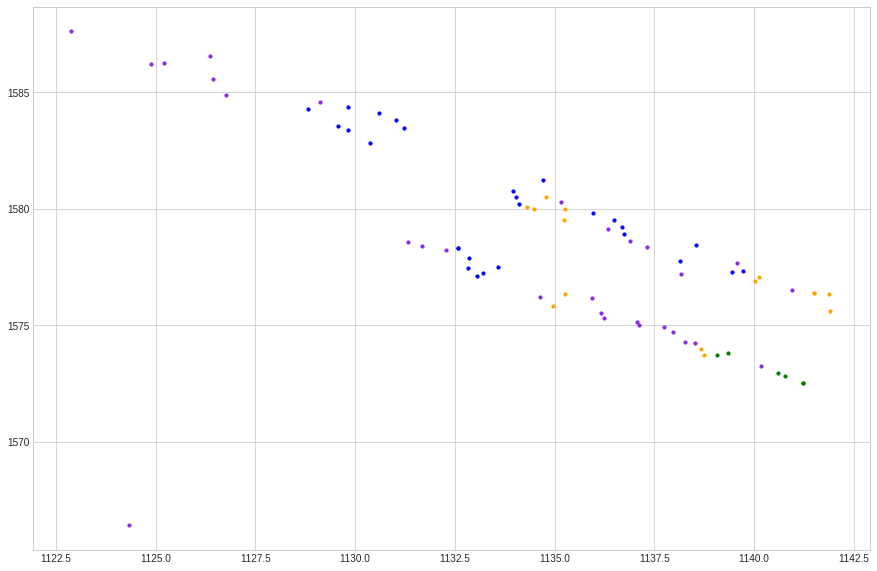

In [91]:
from sklearn.cluster import DBSCAN

fig, ax = plt.subplots(1,1,figsize=(15,10))
colors = ['blue','orange','green','red','black','pink','yellow','purple',"brown","firebrick","coral","lime",
                      "wheat", "yellowgreen", "lightyellow", "skyblue", "cyan", "chocolate", "maroon", "peru", "blueviolet"]

for t in range(0,20):
    pc = dataset.getDynamicPoints(t)
    pc = np.squeeze(pc[np.where(pc[:,3]==0) or np.where(pc[:,3]==2) or np.where(pc[:,3]==6), :], axis=0)
    clus = DBSCAN(eps=2, min_samples=2).fit(pc[:,0:2])
    c = clus.labels_
    for i in range(pc.shape[0]):
        v_comp = np.sqrt(pc[i,8]**2 + pc[i,9]**2)
        if v_comp > 3:
            #c = int(np.round(v_comp) % 17)
            ax.scatter(pc[i,0], pc[i,1], s=10, c=colors[c[i]])

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 1


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 0


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 0


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 0


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 0


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 0


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 0


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 0


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 0


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 0


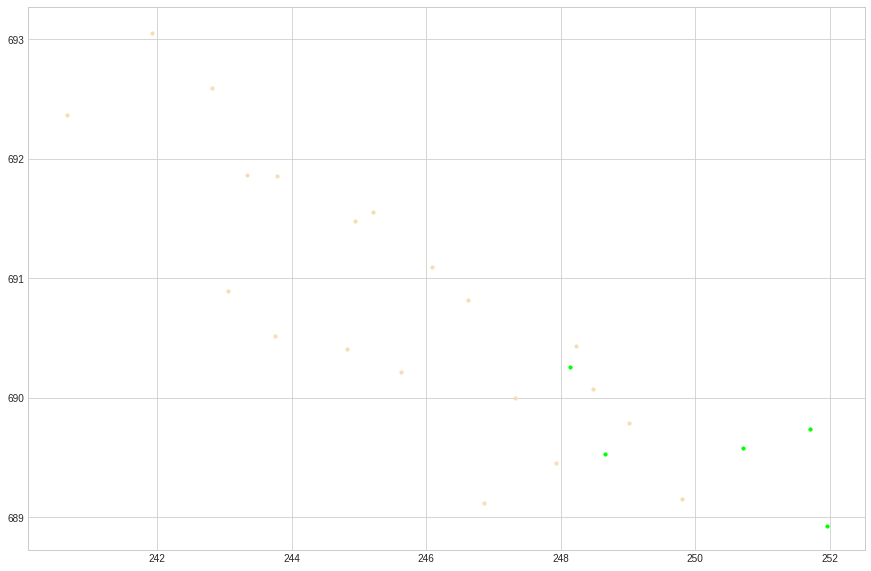

In [470]:
from sklearn.cluster import DBSCAN

fig, ax = plt.subplots(1,1,figsize=(15,10))
colors = ['blue','orange','green','red','black','pink','yellow','purple',"brown","firebrick","coral","lime",
                      "wheat", "yellowgreen", "lightyellow", "skyblue", "cyan", "chocolate", "maroon", "peru", "blueviolet"]

for t in range(0,10):
    pc, ts = dataset.getDynamicPoints(t)
    if pc.shape[0] < 1:
        continue
    clus = DBSCAN(eps=3, min_samples=2).fit(pc[:,0:2+8:9])
    c = clus.labels_
    n_clusters = np.unique(c)
    print(f"n_clusters {len(n_clusters)-1}")
    for i in n_clusters:
        if c[i] == -1:
            continue
        x_com = pc[c==i,0]
        y_com = pc[c==i,1]
        vx_com = np.mean(pc[c==i,8])
        vy_com = np.mean(pc[c==i,9])
        if np.mean(y_com) < 670:
            #print(f"pc[c==i,:] = {pc[c==i,:]}")
            print(f"vx_com={vx_com} vy_com={vy_com} pc[c==i,6]={pc[c==i,6]} pc[c==i,7]={pc[c==i,7]}")
        #print(f"vy_com={vy_com}")
        v_comp = np.sqrt(vx_com**2 + vy_com**2)
        if v_comp > 3:
            color = int(np.round(v_comp) % 17)
            ax.scatter(x_com, y_com, s=10, c=colors[color])

In [510]:
from sklearn.cluster import DBSCAN
import numpy as np
import math

def calcClusterProperiesArray(ci, ego, heading):
    x_com = np.mean(ci[:,0])
    y_com = np.mean(ci[:,1])
    m = (y_com-ego[1])/(x_com-ego[0])
    m_angle = math.atan(m)
    dx = x_com-ego[0]
    dy = y_com-ego[1]
    R = np.array([[np.cos(-heading), -np.sin(-heading)], [np.sin(-heading), np.cos(-heading)]])
    transformed_target = np.dot(R, np.array([x_com-ego[0], y_com-ego[1]]))
    vx_com = 1*np.mean(ci[:,6])
    vy_com = 1*np.mean(ci[:,7])
    dx = transformed_target[0]
    dy = transformed_target[1]
    r = np.sqrt(dx**2+dy**2)
    phi = math.atan2(dx, dy)
    vr = np.sign(vx_com) * np.sqrt(vx_com**2+vy_com**2)
    if vr < 0:
        print(f"r={r} phi={phi} vr={vr}, vx_com={vx_com} vy_com={vy_com}")

    X = np.array([r, phi, vr])
    P = np.diag([2, 0.01, 0.25])
    
    return X,P

def calcClusterProperiesScalar(ci, ego):
    x_com = ci[0]
    y_com = ci[1]
    vx_com = ci[8]
    vy_com = ci[9]
    v_comp = np.sqrt(vx_com**2 + vy_com**2)
    if v_comp < 2:
        return None, None
    x_var = ci[0] + 2
    y_var = ci[1] + 2
    vx_var = ci[8] + 0.5
    vy_var = ci[9] + 0.5
    X = np.array([x_com, y_com, vx_com, vy_com])
    P = np.diag([x_var, y_var, vx_var, vy_var])
    
    return X,P


def runClustering(pc, ego, heading):
    X_list = []
    P_list = []
    
    if pc.shape[0] < 1:
        return X_list, P_list
    clus = DBSCAN(eps=3, min_samples=2).fit(pc[:,0:2+6:8])
    c = clus.labels_
    n_clusters = np.unique(c)
    for i in n_clusters:
        ci = pc[c==i, :]
        if i == -1:
            continue #don't consider 1 point clusters
            for j in range(ci.shape[0]):
                X, P = calcClusterProperiesScalar(ci[j, :])
                if X is not None:
                    X_list.append(X)
                    P_list.append(P)
        else:
            X, P = calcClusterProperiesArray(ci, ego, heading)
            if X is not None:
                X_list.append(X)
                P_list.append(P)
        
    return X_list, P_list

In [713]:
n_frames = 10
ego_path = dataset.getEgoPath()[:n_frames]
tracker = DynamicTracker()
last_heading = 0
last_ego = ego_path[0]
for t in range(0,n_frames):
    pc, ts, heading = dataset.getDynamicPoints(t)
    print(ego_path[t])
    X, P = runClustering(pc, ego_path[t], np.deg2rad(heading-180))
    print(f"X={X}")
    dheading = heading - last_heading
    dR = np.array([[np.cos(dheading), -np.sin(dheading)], [np.sin(dheading), np.cos(dheading)]])
    ego = ego_path[t]
    print(ego,last_ego)
    dT = np.array(ego[0:2]-last_ego[0:2])
    tracker.run(X, P, ts, dR, dT)
    last_heading = heading
    last_ego = ego
    


/home/kfir/workspace/RadarLocalization/dataset.py:262: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  timestamp = self.ego.iloc[eidx]["timestamp"] / 1e6


[309.1439659  668.77989518   0.        ]
X=[array([60.89111514, -0.13447594, 11.5       ])]
[309.1439659  668.77989518   0.        ] [309.1439659  668.77989518   0.        ]
Number of new plots 1
Number of dynamic tracks before run() 0
z=[60.89111514 -0.13447594 11.5       ]
z=[60.89111514 -0.13447594 11.5       ]
60.34137358575127 -8.16373302710101 11.396174870926238 -1.5418165621335485
self.kf.x.shape (4, 1)
Initiating new track: x=[[60.34137359]
 [-8.16373303]
 [11.39617487]
 [-1.54181656]]
age = 1 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:262: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  timestamp = self.ego.iloc[eidx]["timestamp"] / 1e6


[309.14396951 668.7798957    0.        ]
X=[array([63.35106363, -0.13863059, 11.5       ])]
[309.14396951 668.7798957    0.        ] [309.1439659  668.77989518   0.        ]
Number of new plots 1
Number of dynamic tracks before run() 1
(4, 1)
(4, 1)
(4, 1)
hx.shape=(3, 1)
z_pred.shape=(3, 1) z_pred_reshaped.shape=(3, 1)
z=[[63.35106363]
 [-0.13863059]
 [11.5       ]] z_pred=[[61.69682814]
 [-0.13447594]
 [11.5       ]] R=[[0.5  0.   0.  ]
 [0.   0.01 0.  ]
 [0.   0.   0.2 ]]
z=[63.35106363 -0.13863059 11.5       ]
z=[63.35106363 -0.13863059 11.5       ]
62.74328360982268 -8.754291827682387 11.38967082988032 -1.5891502090656286
self.kf.x.shape (4, 1)
Initiating new track: x=[[62.74328361]
 [-8.75429183]
 [11.38967083]
 [-1.58915021]]
age = 2 hits = 1
age = 1 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:262: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  timestamp = self.ego.iloc[eidx]["timestamp"] / 1e6


[309.14397281 668.77989652   0.        ]
X=[array([64.294706  , -0.14752261, 11.5625    ])]
[309.14397281 668.77989652   0.        ] [309.14396951 668.7798957    0.        ]
Number of new plots 1
Number of dynamic tracks before run() 2
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
hx.shape=(3, 1)
z_pred.shape=(3, 1) z_pred_reshaped.shape=(3, 1)
z=[[64.294706  ]
 [-0.14752261]
 [11.5625    ]] z_pred=[[62.55916714]
 [-0.13447594]
 [11.5       ]] R=[[0.5  0.   0.  ]
 [0.   0.01 0.  ]
 [0.   0.   0.2 ]]
hx.shape=(3, 1)
z_pred.shape=(3, 1) z_pred_reshaped.shape=(3, 1)
z=[[64.294706  ]
 [-0.14752261]
 [11.5625    ]] z_pred=[[64.21340263]
 [-0.13863059]
 [11.5       ]] R=[[0.5  0.   0.  ]
 [0.   0.01 0.  ]
 [0.   0.   0.2 ]]
Updating track = 1 z = [[64.294706  ]
 [-0.14752261]
 [11.5625    ]] cov=[[2.   0.   0.  ]
 [0.   0.01 0.  ]
 [0.   0.   0.25]]
zm.shape=(3, 1)
z=[[64.294706  ]
 [-0.14752261]
 [11.5625    ]] z.shape=(3, 1)
H [[ 9.90406159e-01 -1.38186975e-01  0.00000000e+00  0.00000000e+00]


/home/kfir/workspace/RadarLocalization/dataset.py:262: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  timestamp = self.ego.iloc[eidx]["timestamp"] / 1e6


[309.14397373 668.77989834   0.        ]
X=[array([64.99155753, -0.14122818, 11.75      ])]
[309.14397373 668.77989834   0.        ] [309.14397281 668.77989652   0.        ]
Number of new plots 1
Number of dynamic tracks before run() 2
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
hx.shape=(3, 1)
z_pred.shape=(3, 1) z_pred_reshaped.shape=(3, 1)
z=[[64.99155753]
 [-0.14122818]
 [11.75      ]] z_pred=[[63.36574264]
 [-0.13447594]
 [11.5       ]] R=[[0.5  0.   0.  ]
 [0.   0.01 0.  ]
 [0.   0.   0.2 ]]
hx.shape=(3, 1)
z_pred.shape=(3, 1) z_pred_reshaped.shape=(3, 1)
z=[[64.99155753]
 [-0.14122818]
 [11.75      ]] z_pred=[[65.08008048]
 [-0.13886067]
 [11.5620322 ]] R=[[0.5  0.   0.  ]
 [0.   0.01 0.  ]
 [0.   0.   0.2 ]]
Updating track = 1 z = [[64.99155753]
 [-0.14122818]
 [11.75      ]] cov=[[2.   0.   0.  ]
 [0.   0.01 0.  ]
 [0.   0.   0.25]]
zm.shape=(3, 1)
z=[[64.99155753]
 [-0.14122818]
 [11.75      ]] z.shape=(3, 1)
H [[ 9.90374339e-01 -1.38414846e-01  0.00000000e+00  0.00000000e+00]


/home/kfir/workspace/RadarLocalization/dataset.py:262: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  timestamp = self.ego.iloc[eidx]["timestamp"] / 1e6


[309.14397282 668.77990124   0.        ]
X=[array([65.7427727 , -0.14570624, 11.75      ])]
[309.14397282 668.77990124   0.        ] [309.14397373 668.77989834   0.        ]
Number of new plots 1
Number of dynamic tracks before run() 2
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
hx.shape=(3, 1)
z_pred.shape=(3, 1) z_pred_reshaped.shape=(3, 1)
z=[[65.7427727 ]
 [-0.14570624]
 [11.75      ]] z_pred=[[64.22728814]
 [-0.13447594]
 [11.5       ]] R=[[0.5  0.   0.  ]
 [0.   0.01 0.  ]
 [0.   0.   0.2 ]]
hx.shape=(3, 1)
z_pred.shape=(3, 1) z_pred_reshaped.shape=(3, 1)
z=[[65.7427727 ]
 [-0.14570624]
 [11.75      ]] z_pred=[[65.92357593]
 [-0.13894219]
 [11.663538  ]] R=[[0.5  0.   0.  ]
 [0.   0.01 0.  ]
 [0.   0.   0.2 ]]
Updating track = 1 z = [[65.7427727 ]
 [-0.14570624]
 [11.75      ]] cov=[[2.   0.   0.  ]
 [0.   0.01 0.  ]
 [0.   0.   0.25]]
zm.shape=(3, 1)
z=[[65.7427727 ]
 [-0.14570624]
 [11.75      ]] z.shape=(3, 1)
H [[ 9.90363052e-01 -1.38495580e-01  0.00000000e+00  0.00000000e+00]


/home/kfir/workspace/RadarLocalization/dataset.py:262: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  timestamp = self.ego.iloc[eidx]["timestamp"] / 1e6


[309.14397005 668.77990489   0.        ]
X=[array([66.61775525, -0.14221401, 12.        ])]
[309.14397005 668.77990489   0.        ] [309.14397282 668.77990124   0.        ]
Number of new plots 1
Number of dynamic tracks before run() 2
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
hx.shape=(3, 1)
z_pred.shape=(3, 1) z_pred_reshaped.shape=(3, 1)
z=[[66.61775525]
 [-0.14221401]
 [12.        ]] z_pred=[[65.03252964]
 [-0.13447594]
 [11.5       ]] R=[[0.5  0.   0.  ]
 [0.   0.01 0.  ]
 [0.   0.   0.2 ]]
hx.shape=(3, 1)
z_pred.shape=(3, 1) z_pred_reshaped.shape=(3, 1)
z=[[66.61775525]
 [-0.14221401]
 [12.        ]] z_pred=[[66.69359498]
 [-0.13919068]
 [11.69963672]] R=[[0.5  0.   0.  ]
 [0.   0.01 0.  ]
 [0.   0.   0.2 ]]
Updating track = 1 z = [[66.61775525]
 [-0.14221401]
 [12.        ]] cov=[[2.   0.   0.  ]
 [0.   0.01 0.  ]
 [0.   0.   0.25]]
zm.shape=(3, 1)
z=[[66.61775525]
 [-0.14221401]
 [12.        ]] z.shape=(3, 1)
H [[ 9.90328608e-01 -1.38741663e-01  0.00000000e+00  0.00000000e+00]


/home/kfir/workspace/RadarLocalization/dataset.py:262: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  timestamp = self.ego.iloc[eidx]["timestamp"] / 1e6


[309.14396754 668.7799106    0.        ]
X=[array([68.29180417, -0.14452685, 12.        ])]
[309.14396754 668.7799106    0.        ] [309.14397005 668.77990489   0.        ]
Number of new plots 1
Number of dynamic tracks before run() 2
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
hx.shape=(3, 1)
z_pred.shape=(3, 1) z_pred_reshaped.shape=(3, 1)
z=[[68.29180417]
 [-0.14452685]
 [12.        ]] z_pred=[[66.70471014]
 [-0.13447594]
 [11.5       ]] R=[[0.5  0.   0.  ]
 [0.   0.01 0.  ]
 [0.   0.   0.2 ]]
hx.shape=(3, 1)
z_pred.shape=(3, 1) z_pred_reshaped.shape=(3, 1)
z=[[68.29180417]
 [-0.14452685]
 [12.        ]] z_pred=[[68.40484194]
 [-0.1394207 ]
 [11.8183402 ]] R=[[0.5  0.   0.  ]
 [0.   0.01 0.  ]
 [0.   0.   0.2 ]]
Updating track = 1 z = [[68.29180417]
 [-0.14452685]
 [12.        ]] cov=[[2.   0.   0.  ]
 [0.   0.01 0.  ]
 [0.   0.   0.25]]
zm.shape=(3, 1)
z=[[68.29180417]
 [-0.14452685]
 [12.        ]] z.shape=(3, 1)
H [[ 9.90296667e-01 -1.38969462e-01  0.00000000e+00  0.00000000e+00]


/home/kfir/workspace/RadarLocalization/dataset.py:262: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  timestamp = self.ego.iloc[eidx]["timestamp"] / 1e6


[309.14397254 668.77991022   0.        ]
X=[array([69.21463214, -0.14253628, 12.        ])]
[309.14397254 668.77991022   0.        ] [309.14396754 668.7799106    0.        ]
Number of new plots 1
Number of dynamic tracks before run() 1
(4, 1)
(4, 1)
(4, 1)
hx.shape=(3, 1)
z_pred.shape=(3, 1) z_pred_reshaped.shape=(3, 1)
z=[[69.21463214]
 [-0.14253628]
 [12.        ]] z_pred=[[69.28405644]
 [-0.13978551]
 [11.91994603]] R=[[0.5  0.   0.  ]
 [0.   0.01 0.  ]
 [0.   0.   0.2 ]]
Updating track = 0 z = [[69.21463214]
 [-0.14253628]
 [12.        ]] cov=[[2.   0.   0.  ]
 [0.   0.01 0.  ]
 [0.   0.   0.25]]
zm.shape=(3, 1)
z=[[69.21463214]
 [-0.14253628]
 [12.        ]] z.shape=(3, 1)
H [[ 9.90245904e-01 -1.39330718e-01  0.00000000e+00  0.00000000e+00]
 [ 2.01100693e-03  1.42925509e-02  0.00000000e+00  0.00000000e+00]
 [-1.44553909e-04 -1.02736797e-03  9.90245904e-01 -1.39330718e-01]]
S.shape (3, 3)
hx.shape=(3, 1)
age = 7 hits = 7


/home/kfir/workspace/RadarLocalization/dataset.py:262: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  timestamp = self.ego.iloc[eidx]["timestamp"] / 1e6


[309.1439784  668.77990923   0.        ]
X=[array([70.18184531, -0.14482317, 12.        ])]
[309.1439784  668.77990923   0.        ] [309.14397254 668.77991022   0.        ]
Number of new plots 1
Number of dynamic tracks before run() 1
(4, 1)
(4, 1)
(4, 1)
hx.shape=(3, 1)
z_pred.shape=(3, 1) z_pred_reshaped.shape=(3, 1)
z=[[70.18184531]
 [-0.14482317]
 [12.        ]] z_pred=[[70.11371141]
 [-0.14005327]
 [11.95465982]] R=[[0.5  0.   0.  ]
 [0.   0.01 0.  ]
 [0.   0.   0.2 ]]
Updating track = 0 z = [[70.18184531]
 [-0.14482317]
 [12.        ]] cov=[[2.   0.   0.  ]
 [0.   0.01 0.  ]
 [0.   0.   0.25]]
zm.shape=(3, 1)
z=[[70.18184531]
 [-0.14482317]
 [12.        ]] z.shape=(3, 1)
H [[ 9.90208561e-01 -1.39595864e-01  0.00000000e+00  0.00000000e+00]
 [ 1.99099237e-03  1.41228947e-02  0.00000000e+00  0.00000000e+00]
 [-1.74087246e-04 -1.23486954e-03  9.90208561e-01 -1.39595864e-01]]
S.shape (3, 3)
hx.shape=(3, 1)
age = 8 hits = 8
[309.14398318 668.77990884   0.        ]
X=[array([71.0636920

/home/kfir/workspace/RadarLocalization/dataset.py:262: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  timestamp = self.ego.iloc[eidx]["timestamp"] / 1e6


Total number of tracks = 2
['likelihood', 'log_likelihood', 'mahalanobis', 'dim_x', 'dim_z', 'dim_u', 'x', 'P', 'B', 'F', 'R', 'Q', 'y', 'z', 'K', 'S', 'SI', '_I', '_log_likelihood', '_likelihood', '_mahalanobis', 'x_prior', 'P_prior', 'x_post', 'P_post'] [array([[0.],
       [0.],
       [0.],
       [0.]]), array([[0.],
       [0.],
       [0.],
       [0.]]), array([[0.],
       [0.],
       [0.],
       [0.]]), array([[0.],
       [0.],
       [0.],
       [0.]]), array([[0.],
       [0.],
       [0.],
       [0.]]), array([[0.],
       [0.],
       [0.],
       [0.]]), array([[0.],
       [0.],
       [0.],
       [0.]])]
[[[0.]
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  [0.]]]
(7, 4, 1)
['likelihood', 'log_likelihood', 'mahalanobis', 'dim_x', 'dim_z', 'dim_u', 'x', 'P', 'B', 'F', 'R', 'Q', 'y', 'z', 'K', 'S', 'SI', '_I', '_log_li

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:116: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


ValueError: could not broadcast input array from shape (4,1) into shape (4)

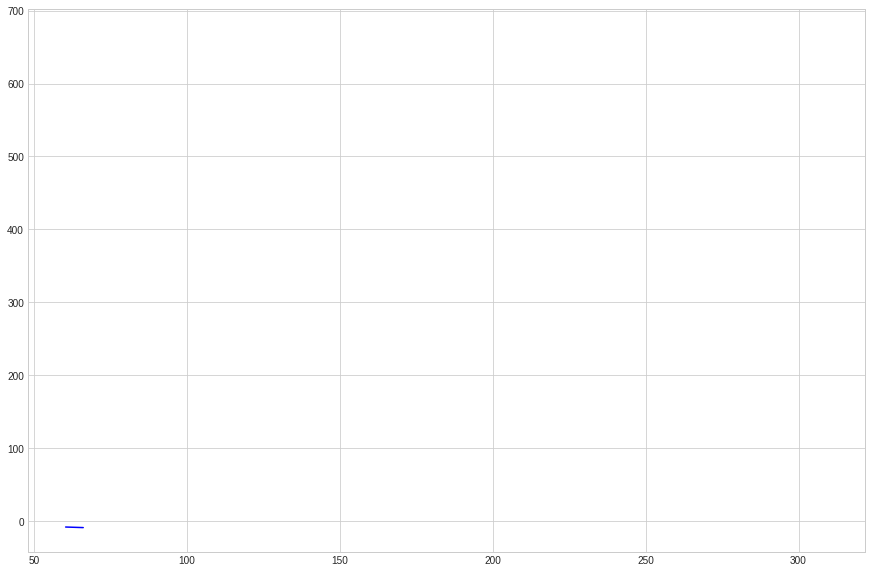

In [714]:
tracks = tracker.getHistory()
N = len(tracks)
print(f"Total number of tracks = {N}")

fig, ax = plt.subplots(1,1,figsize=(15,10))
colors = ['blue','orange','green','red','black','pink','yellow','purple',"brown","firebrick","coral","lime",
                      "wheat", "yellowgreen", "lightyellow", "skyblue", "cyan", "chocolate", "maroon", "peru", "blueviolet"]

ego_path = dataset.getEgoPath()[:n_frames]
ax.plot(ego_path[:,0], ego_path[:,1])
for idx,trk in enumerate(tracks):
    if 1:#trk.confirmed:
        history = trk.getHistory()
        print(history.shape)
        ax.plot(history[:,0], history[:,1], color=colors[idx])
        history_len = history.shape[0]
        dx = history[int(history_len / 2) + 1,0]-history[int(history_len / 2) - 1,0]
        dy = history[int(history_len / 2) + 1,1]-history[int(history_len / 2) - 1,1]
        #ax.arrow(np.mean(history[:,0]), np.mean(history[:,1]), dx[0], dy[0], shape='full', lw=13, length_includes_head=True, head_width=.05)

In [497]:
np.rad2deg(math.atan(21/59))

19.592281891051528

In [502]:
np.rad2deg(-0.14221401)

-8.148262560631284